# THIS NOTEBOOK IS DEDICATED TO THE ANALYSIS OF 

# *SEQ SCORE / WAITING TIME*


In [70]:
import os
import glob
import numpy as np
from platform import system as OS
import pandas as pd
import scipy.stats
import math
import datetime
from copy import deepcopy
from IPython.display import clear_output, display, HTML, Image
import matplotlib.cm as cm
import warnings
import types
warnings.filterwarnings("ignore")
import sys, time
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import mlab
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from pylab import *
import matplotlib.backends.backend_pdf
from sklearn.decomposition import KernelPCA

ThisNoteBookPath=os.path.dirname(os.path.realpath("__file__"))
CommonNoteBookesPath=os.path.join(os.path.split(ThisNoteBookPath)[0],"load_preprocess_rat")
CWD=os.getcwd()
os.chdir(CommonNoteBookesPath)
root='/data'
%run UtilityTools.ipynb
%run Animal_Tags.ipynb
%run Lesion_Size.ipynb
%run BatchRatBehavior.ipynb
%run plotRat_documentation_3_KinematicsInvestigation.ipynb
%run plotRat_documentation_1_GeneralBehavior.ipynb
%run loadRat_documentation.ipynb
%run RunBatchRat_3_CompareGroups.ipynb
os.chdir(CWD)

param={
    "binSize":0.25,
    "trialOffset":20., #max end of trial, in seconds (position will be cutted)
    "sigmaSmoothPosition":0.1,  #smooth the position
    #"sigmaSmoothPosition":0.33 for pavel dataType
    "sigmaSmoothSpeed":0.3, #smooth the speed
    "positionDiffRange": [2.,5.], #min and max differences allowed between two consecutive positions
                                  #min to correct start, max to correct jumps
    "pawFrequencyRange":[2.,10.],
    "startAnalysisParams":[10,0.2,0.5],
    "cameraToTreadmillDelay":2., #seconds, usual time between camera start and treadmill start
    "nbJumpMax" : 100., #if jumps>nbJumpMax, trial is badly tracked
    
    
    #parameter to detect end of trial (first position minima)
    "endTrial_backPos":55,  # minima is after the animal went once to the back (after first time position>backPos)
    "endTrial_frontPos":30, # minima's position is in front of treadmill (position[end]<frontPos)
    "endTrial_minTimeSec":4, # minima is after minTimeSec seconds (time[end]>minTimeSec)
    }
Y1,Y2=(0,90)
BadLateRats=('Rat223','Rat231')
print('Done')

Done


## motor seq score

In [16]:
def plot_event_1on1(root, SessionDict, TaskParamToPlot,
                    ax=None, preSlice=slice(-5,None), postSlice=slice(0,5)):
    
    Plot = True
    if ax is None:
        Plot=False
    
    
    Results,nSessionPre,nSessionPost=event_statistic(root,
                                                     SessionDict,
                                                     parameter=param,
                                                     redo=False,
                                                     TaskParamToPlot=[TaskParamToPlot])

    data=np.array(list(Results[TaskParamToPlot].values()))
    slicedPreData  = np.ones((data.shape))*np.nan
    slicedPostData = np.ones((data.shape))*np.nan
    
    for row,Dnan in enumerate(data):
        Dpre= Dnan[:nSessionPre][~ np.isnan(Dnan[:nSessionPre])]
        Dpost=Dnan[nSessionPre:][~ np.isnan(Dnan[nSessionPre:])]
        preData =Dpre[preSlice]
        postData=Dpost[postSlice]

        slicedPreData[row,:len(preData)]=preData
        slicedPostData[row,:len(postData)]=postData
    
    y0=np.nanmean(slicedPreData,axis=1)
    y1=np.nanmean(slicedPostData,axis=1)
    
    y=np.array([y0,y1]).T
    
    if Plot:
        #plotting the errorbar
        props={'color':'k','linewidth':1}
        ax.boxplot(x=y,whis=[5,95],
                      positions=[-.5,.5], widths=.3,
                      showcaps=False, showfliers=False,
                      medianprops=props, boxprops=props, whiskerprops=props,
                      zorder=2)

        #plotting single animals
        for before,after in y:
            ax.plot([-.5,.5],[before,after],lw=.5,alpha=1,zorder=1)
        
    return y, slicedPreData, slicedPostData

In [68]:
profile1={'Type':'Good',
         'rewardType':'Progressive',
         'initialSpeed':['0','10'],
         'Speed':'10',
         'Tag':['Control', 'Control-AfterBreak', 'Control-Late-NoTimeout-BackToTimeout',
          'Control-NoTimeout-Control','Control-Sharp','IncReward-Late-Sharp',
          'Control-Sharp-AfterBreak','ImmobileTreadmill-Control']
         }
profile2={'Type':'Good',
         'rewardType':'Progressive',
         'initialSpeed':['0','10'],
         'Speed':'10',
         'Tag':['Late-Lesion_DLS','Late-Lesion_DMS','Late-Lesion_DS',
                'Late-Lesion_DS-Sharp','Late-Lesion_DMS-Sharp']
         }

Profiles=(profile1,profile2)
TaskParamToPlot=["Motor Sequence Score","Maximum Position"]
preSlice=slice(-5,None)
postSlice=slice(-5,None)

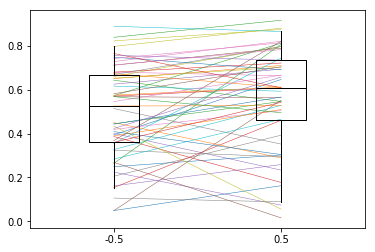

In [100]:
badAnimalList=[]
for i,animal in enumerate(SessionDict.keys()):
    if animal in BadLateRats: #low seq score
        badAnimalList.append(animal)


F=plt.figure(1)
ax=F.add_subplot(111)

_,SessionDict=event_detect(root, Profiles[0], Profiles[1])
y, nSessionPre, slicedPostData=plot_event_1on1(root,SessionDict, TaskParamToPlot=TaskParamToPlot[0],ax=ax,
                preSlice=preSlice, postSlice=postSlice);
clear_output()
F

In [99]:
for i,animal in enumerate(SessionDict.keys()):
    print(i, animal,y[i,0],y[i,1],y[i,1]-y[i,0] ,sep='\t')
#     if y[i,1] < 0.4:
#         print(i, animal, y[i,0],y[i,1], sep='\t')


0	Rat139	0.24884818610332768	0.3024062428277664	0.053558056724438724
1	Rat137	0.6509273301136567	0.7108458554862895	0.05991852537263287
2	Rat254	0.6435807562560975	0.5468366127914077	-0.09674414346468974
3	Rat301	0.5710068699012452	0.608707281777269	0.0377004118760238
4	Rat122	0.6256636271529888	0.6943136573571357	0.06865003020414684
5	Rat302	0.7121087565460967	0.7898582843358962	0.07774952778979949
6	Rat308	0.6808169934640523	0.6641238253178552	-0.016693168146197146
7	Rat141	0.5143138706630243	0.35181563490173895	-0.1624982357612853
8	Rat164	0.6604987685434447	0.7974047748941366	0.13690600635069194
9	Rat256	0.3551710143379702	0.7443861581446287	0.3892151438066585
10	Rat217	0.3940249282829603	0.6470548487909052	0.2530299205079449
11	Rat264	0.4501073422069558	0.28837553385894715	-0.16173180834800865
12	Rat227	0.5727051826407773	0.8134112617580957	0.24070607911731845
13	Rat260	0.3865099969711191	0.17665334466762223	-0.20985665230349687
14	Rat123	0.40080002009182875	0.23303974128314012	-0

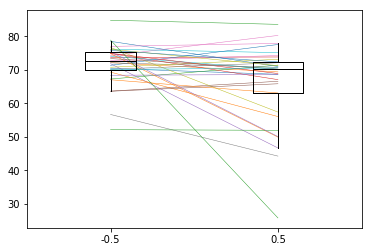

In [97]:
badAnimalList=[]
for i,animal in enumerate(SessionDict.keys()):
    if y[i,0] < 0.4 or y[i,1] < 0.4 or animal in BadLateRats: #low seq score
        badAnimalList.append(animal)

F=plt.figure(2)
ax=F.add_subplot(111)

_,SessionDict1=event_detect(root, Profiles[0], Profiles[1],badAnimals=badAnimalList)
y1, nSessionPre1, slicedPostData1=plot_event_1on1(root,SessionDict1, TaskParamToPlot=TaskParamToPlot[1],ax=ax,
                                                  preSlice=slice(-2,None), postSlice=slice(0,3));
clear_output()
F

In [98]:
for i,animal in enumerate(SessionDict1.keys()):
    print(i, animal,y1[i,0],y1[i,1],y1[i,1]-y1[i,0] ,sep='\t')
#     if y[i,1] < 0.4:
#         print(i, animal, y[i,0],y[i,1], sep='\t')


0	Rat137	70.37259492844231	68.63100732692295	-1.741587601519356
1	Rat254	72.11703961519257	69.34660659284968	-2.7704330223428855
2	Rat301	67.2251159749713	71.37308756259897	4.147971587627666
3	Rat122	73.65627519386165	73.80457612451744	0.1483009306557932
4	Rat302	71.80612626187789	46.6616030711499	-25.144523190727995
5	Rat308	63.61466160450757	66.5473745334893	2.9327129289817364
6	Rat164	74.17460161572939	80.23140927821395	6.056807662484559
7	Rat227	56.65019242614599	44.22530310630297	-12.424889319843025
8	Rat225	76.62231303008647	57.369499266153525	-19.25281376393295
9	Rat113	76.12939451826664	75.10285094113767	-1.0265435771289617
10	Rat161	71.32141259475596	77.52325322765454	6.2018406328985805
11	Rat255	69.29102566578987	56.026876740722535	-13.264148925067339
12	Rat232	84.7614566384037	83.5360540003086	-1.2254026380951046
13	Rat299	74.83602709710837	67.04134168861505	-7.794685408493322
14	Rat131	68.35124894941832	68.56962244088345	0.21837349146512963
15	Rat140	63.57480694440386	65.80

In [51]:
x=y1[:,0]-y1[:,1]
# x[y[:,0]<3.5]=np.nan
x=x[~ np.isnan(x)]
q=np.random.normal(loc=0.0, scale=np.std(x), size=(500,1))
p=permtest(x=x, y=q, iterN=10000)

In [52]:
p.p_val

array([0.0059994])